In [22]:
import numpy as np
from scipy import stats 
import pandas as pd
from tqdm import tqdm_notebook
import cdpm
import pandas_datareader as pd_reader
from sklearn.preprocessing import add_dummy_feature
import matplotlib as mpl
import tables
import os
from multiprocessing import Pool, Lock

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3, suppress=True)

In [3]:
num_draws = int(1e1)
include_mean = True

In [4]:
filename = '../results/expanding_monthly_estimate.tmp.hdf'
var_filename = '../results/expanding_monthly_var_estimate.tmp.hdf'

In [5]:
cdpm.__version__

'0.01.32-py36_2'

In [6]:
rel_cols = ['UNRATE']

## Import the data

In [7]:
data = pd_reader.data.DataReader('UNRATE', data_source='fred', start='1960', end='2017')
data.columns = ['UNRATE']
fred_cpi = pd_reader.data.DataReader('CPIAUCSL', data_source='fred', start='1960', end='2017').apply(np.log).diff()
fred_homesupply = pd_reader.data.DataReader('MSACSR', data_source='fred', start='1960', end='2017')
fred_rconsmp = pd_reader.data.DataReader('DPCERAM1M225NBEA', data_source='fred', start='1960', end='2017')
fred_prod = pd_reader.data.DataReader('INDPRO', data_source='fred', start='1960', end='2017').apply(np.log).diff()
data['INFLA'] = fred_cpi
data['HSUPPLY'] = fred_homesupply
data['RCONSMP'] = fred_rconsmp
data = data[rel_cols].dropna().transform(stats.zscore)

In [8]:
data.head()

UNRATE
DATE                
1960-01-01 -0.549925
1960-02-01 -0.803168
1960-03-01 -0.423304
1960-04-01 -0.549925
1960-05-01 -0.613236

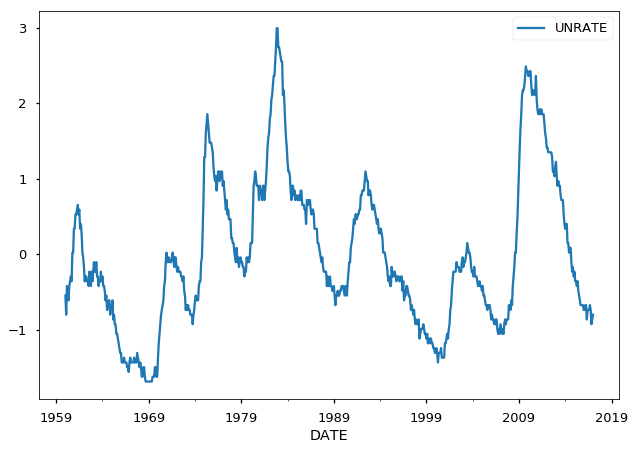

In [9]:
data.plot()

In [10]:
data.describe()

UNRATE
count  6.850000e+02
mean   1.191261e-16
std    1.000731e+00
min   -1.689519e+00
25%   -6.765469e-01
50%   -2.333717e-01
75%    6.529787e-01
max    2.995476e+00

In [11]:
time_dim = data.shape[0]

regressor_dim = data.shape[1] + int(include_mean)
regressand_dim = data.shape[1]

## Estimation

In [12]:
stick_scale = 8
# mean and standard deviation
beta_mu, beta_sigma = .5 * np.eye(regressand_dim,regressor_dim, k=-1), .25 * np.eye(regressor_dim, regressor_dim) 
comp_cov_df = regressand_dim + 2
comp_cov_scale = .5 * comp_cov_df * np.eye(regressand_dim)

In [13]:
prior = {
    'comp': {
        'coeff': {'mean':list(beta_mu.ravel()), 'cov': list(beta_sigma.ravel())},
        'cov': {'scale': list(comp_cov_scale.ravel()), 'df': [comp_cov_df]}
    },
    'sticks': {
        'params': {
            'c': [stick_scale]
        }
    }
}

In [173]:
def save_cdpm_results(num_draws, model_it, prior,  loc_it, data, max_cluster_dim=50, include_mean=True,
                      filename='../results/expanding_estimates.tmp.hdf'):
    
    float_atom = tables.Atom.from_dtype(np.dtype(np.float64))
    regressor_dim = data.shape[1] + include_mean
    regressand_dim = data.shape[1]
    time_dim = data.shape[0] - 1
    lock = Lock()
    
    with tables.File(filename, 'a') as file:
        
        data_index = data.index.strftime('%Y-%m-%d')
        
        if data is not None:
            file.create_earray(where='/', name='data', obj=data.values)
            file.create_earray(where='/', name='data_index', obj=data.index.strftime('%Y-%m-%d'))
            file.create_earray(where='/', name='data_columns',
                           obj=np.array(data.columns).astype(np.string_))
        
#         for loc, model in zip(loc_it, model_it):
        def save_draws_in(it):
            loc, model = it
            with lock:
                file.create_group(where='/', name=loc)
                file.create_earray(where='/' + loc, name='beta', atom=float_atom, expectedrows=num_draws, 
                                    shape=(0,max_cluster_dim,regressor_dim, regressand_dim))
                file.create_earray(where='/' + loc, name='sticks', atom=float_atom,
                                   shape=(0,max_cluster_dim), expectedrows=num_draws)
                file.create_earray(where='/' + loc, name='comp_cov', atom=float_atom, expectedrows=num_draws,
                                   shape=(0, max_cluster_dim, regressand_dim, regressand_dim))
                file.create_earray(where='/' + loc, name='trans_mat', atom=float_atom,
                                   shape=(0, max_cluster_dim, max_cluster_dim), expectedrows=num_draws)
                file.create_earray(where='/' + loc, name='cluster_identity', atom=float_atom,
                                   shape=(0, time_dim), expectedrows=num_draws)
            
            draws = [get_draws(model, prior, max_cluster_dim, time_dim) for draw_idx in range(num_draws)]
            append_draws(file, loc, draws)
        for val in zip(tqdm_notebook(loc_it), model_it):
            save_draws_in(val)
#         map(save_draws_in, zip(loc_it, model_it))
#         [save_draws_in(val) for val in zip(loc_it, model_it)]
#         print(list(zip(loc_it, model_it)))
    
    

In [174]:
def append_draws(file, loc, draws):
    for draw in draws:
        cluster_draws, stick_draws, beta_draws, comp_cov_draws, trans_mat_draws = draw
        file.get_node('/' + loc).cluster_identity.append([cluster_draws])
        file.get_node('/' + loc).beta.append([beta_draws])
        file.get_node('/' + loc).sticks.append([stick_draws])
        file.get_node('/' + loc).trans_mat.append([trans_mat_draws])
        file.get_node('/' + loc).comp_cov.append([comp_cov_draws])  

In [175]:
def get_draws(model, prior, max_cluster_dim, time_dim):
    clusters, sticks, beta, cov, trans_mat = model(prior)
    beta_draws = np.pad(beta, pad_width=((0, max_cluster_dim-beta.shape[0]), (0,0), (0,0)),
                                mode='constant', constant_values=np.nan)
    comp_cov_draws = np.pad(cov, pad_width=((0, max_cluster_dim-cov.shape[0]), (0,0), (0,0)),
                                    mode='constant', constant_values=np.nan)
    trans_mat_draws = np.pad(trans_mat, pad_width=((0, max_cluster_dim-trans_mat.shape[0]),
                                                     (0, max_cluster_dim-trans_mat.shape[0])),
                                     mode='constant', constant_values=np.nan)
    stick_draws =  np.ravel(np.pad(sticks, pad_width=((0, max_cluster_dim-sticks.size)),
                                     mode='constant', constant_values=np.nan))
    cluster_draws =  np.ravel(np.pad(clusters, pad_width=((0, time_dim-clusters.size)),
                    mode='constant', constant_values=np.nan))
    
    return cluster_draws, stick_draws, beta_draws, comp_cov_draws, trans_mat_draws

In [176]:
def expanding_estimate_cdpm(data, prior, num_draws, progress_bar=None, include_mean=True,
                            max_cluster_dim=50, filename='../results/expanding_estimates.tmp.hdf',
                            random_initialization=False, min_periods=600):
    """
    This function estimates the model using the Conditional Dirichet Process Mixture Sampler.

    Parameters
    --------
    beta_mu : array
       The initalization value for the component's coefficients. 
    comp_cov : array
        The  initalizationv value for the component's innovation covariances.
    prior : dict of dicts...
    num_draws : int
    progress_bar : tqdm-like option, optional
    max_cluster_dim : int, optional
    filename : str, optional

    Returns
    ------
    return_dict : dict
        the estimates. 
    """
           
    try:
        os.remove(filename)
    except OSError:
        pass
     
    beta_mu = np.reshape(prior['comp']['coeff']['mean'], (data.shape[1] + include_mean, data.shape[1]))
    comp_cov = (np.reshape(prior['comp']['cov']['scale'], (data.shape[1], data.shape[1]))
                / prior['comp']['cov']['df'])

    model_it = []
    loc_it = []
    for time_idx in range(min_periods, data.shape[0]):
        if include_mean:
            regressor =  pd.DataFrame(add_dummy_feature(data.iloc[:time_idx]), index=data.index[:time_idx],
                             columns=['intercept'] + list(data.columns))
        else:
            regressor = data.iloc[:time_idx]
        regressand = data.iloc[1:time_idx+1]

        model = cdpm.CondDirichletProcessMix(beta_mu, comp_cov=comp_cov, regressor=regressor, regressand=regressand)
        if random_initialization:
            model.gamma = np.random.choice(2, size=model.time_dim)
        loc_it.append(data.index[time_idx].strftime('%b_%d_%y'))
        model_it.append(model)
        
#     if progress_bar is not None:    
#         model_it = progress_bar(model_it)
        
    save_cdpm_results(num_draws=num_draws, model_it=model_it, prior=prior, loc_it=loc_it, data=data, 
                      include_mean=include_mean, max_cluster_dim=max_cluster_dim, filename=filename)
    return expanding_read_results(filename=filename, loc_it=loc_it) 


In [177]:
def expanding_read_results(loc_it, filename='../results/estimates.tmp.hdf'):                                                    
    """                                                                                                            
    Reads the results in the pytables store given in the filanem                                                   
                                                                                                                   
    Parameters                                                                                                     
    ---------                                                                                                      
    filename : str,                                                                                                
                                                                                                                   
    Returns                                                                                                        
    ------                                                                                                         
    return_dict : dict                                                                                             
        the estimates.                                                                                             
    """                      
   
    with tables.File(filename, 'r') as file:

        return_dict = {arr.name : arr.read() for arr in file.iter_nodes(where='/', classname='Array')}  
        
        data_index = pd.to_datetime(return_dict.pop('data_index').astype(str))
        return_dict['data'] = pd.DataFrame(return_dict['data'], index=data_index,
                                              columns=return_dict.pop('data_columns').astype(str))
        if len(loc_it) > 1:
            for loc in loc_it:
                return_dict[loc] = {arr.name : arr.read() for arr in file.walk_nodes(where='/' + loc, 
                                                                                     classname='Array')}                                                                                       
                                                                                                                  
            if 'cluster_identity' in return_dict[loc]:
                cluster_identity = return_dict[loc]['cluster_identity'].T
                return_dict[loc]['cluster_identity'] = pd.DataFrame(cluster_identity,
                                                           index=data_index[:cluster_identity.shape[0]])
        elif 'cluster_identity' in return_dict:
            cluster_identity = return_dict['cluster_identity'].T
            return_dict['cluster_identity'] = pd.DataFrame(cluster_identity,
                                                           index=data_index[:cluster_identity.shape[0]])
                                                                                                                   
    return return_dict    


In [178]:
return_dict = expanding_estimate_cdpm(include_mean=include_mean, num_draws=num_draws, progress_bar=tqdm_notebook,
                                      prior=prior,filename=filename, data=data, random_initialization=True)

HBox(children=(IntProgress(value=0, max=85), HTML(value='')))